In [1]:
%load_ext lab_black

# Introduction
This is intended to explain how the NRG data produced by Yaakov Kleeorin (and Yigal Meir) is used in fitting to experimental data

Note that many of the functions shown here are somewhat over-complicated for the minimal examples presented here, but I have included them in their entirety for completeness. The functions presented here are from a larger package of analysis functions that I developed over several years. It can be found at https://github.com/TimChild/dat_analysis. 

# Setting up Notebook

In [2]:
# Get all the external imports out of the way
# Python built ins
from dataclasses import dataclass
from functools import lru_cache
import datetime
import sys

# Third party imports
import matplotlib
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
import numpy as np
import lmfit as lm
import scipy
import numpy as np
import scipy

print(f"python version: {sys.version}")
print(f"matplotlib version: {matplotlib.__version__}")
print(f"seaborn version: {sns.__version__}")
print(f"numpy version: {np.__version__}")
print(f"lmfit version: {lm.__version__}")
print(f"scipy version: {scipy.__version__}")

python version: 3.10.10 | packaged by Anaconda, Inc. | (main, Mar 21 2023, 18:39:17) [MSC v.1916 64 bit (AMD64)]
matplotlib version: 3.7.1
seaborn version: 0.12.2
numpy version: 1.24.2
lmfit version: 1.1.0
scipy version: 1.10.1


In [3]:
print(f"Notebook last run on {datetime.date.today()}")

Notebook last run on 2023-09-19


In [4]:
%matplotlib inline
mpl.rcParams.update(
    {
        "figure.dpi": 110,  # 27in 1440p = 110
    }
)
# FIG_SCALE -- Set to full width of page (~6in)
FS = 6


def decrease_fontsize(ax, decrease_fs):
    """
    Decrease the font sizes of various elements of a given ax by decrease_fs.

    Parameters:
    - ax: The axes for which font sizes should be decreased.
    - decrease_fs: The amount by which to decrease the font size.
    """
    # Decreasing font size for x and y tick labels
    current_xticks_fs = ax.xaxis.get_ticklabels()[0].get_fontsize()
    current_yticks_fs = ax.yaxis.get_ticklabels()[0].get_fontsize()
    ax.tick_params(axis="x", labelsize=current_xticks_fs - decrease_fs)
    ax.tick_params(axis="y", labelsize=current_yticks_fs - decrease_fs)

    # Decreasing font size for x and y axis labels
    ax.xaxis.label.set_fontsize(ax.xaxis.label.get_fontsize() - decrease_fs)
    ax.yaxis.label.set_fontsize(ax.yaxis.label.get_fontsize() - decrease_fs)

    # Decreasing font size for title
    ax.title.set_fontsize(ax.title.get_fontsize() - decrease_fs)

    # Decreasing font size of axes exponents
    ax.xaxis.get_offset_text().set_fontsize(
        ax.xaxis.get_offset_text().get_fontsize() - decrease_fs
    )
    ax.yaxis.get_offset_text().set_fontsize(
        ax.yaxis.get_offset_text().get_fontsize() - decrease_fs
    )

    # Decreasing font size for legend (if present)
    if ax.get_legend():
        for text in ax.get_legend().get_texts():
            text.set_fontsize(text.get_fontsize() - decrease_fs)

# Loading NRG Calculation data

Now, we'll define a class for loading and holding NRG calculations.

In [5]:
@dataclass
class NRGData:
    ens: np.ndarray
    ts: np.ndarray
    conductance: np.ndarray
    dndt: np.ndarray
    entropy: np.ndarray
    occupation: np.ndarray
    int_dndt: np.ndarray
    gs: np.ndarray

    @classmethod
    @lru_cache
    def from_mat(cls):
        """Combines two new NRG datasets (the first has good thermally broadened data, but isn't wide enough for
        gamma broadened data. The second is more gamma broadened data only over a wider range but with the same density
        of points (i.e. a differently shaped array)

        This combines both and adds NoNs to the narrower data so that they can still be treated as arrays.
        """

        def pad_to_shape(arr: np.ndarray, desired_x_shape: int):
            """Pads array with NaNs so that it has a given x dimension"""
            if arr.shape[-1] > desired_x_shape:
                raise RuntimeError(f"{arr.shape[-1]} > {desired_x_shape}")
            diff = desired_x_shape - arr.shape[-1]
            pads = [(0, 0)] * (arr.ndim - 1)
            pads.extend([(0, diff)])  # Pad all NaNs, at end of data
            return np.pad(arr, pad_width=pads, mode="constant", constant_values=np.nan)

        NRG_DATAS = [
            "Mu_mat",
            "Conductance_mat",
            "DNDT_mat",
            "Entropy_mat",
            "Occupation_mat",
            "intDNDT_mat",
        ]

        # Thermally broadened data (includes gamma broadened which isn't wide enough)
        path = "nrg_calculations/NRGresultsNew.mat"
        data = scipy.io.loadmat(path)
        rows_from_narrow = np.s_[
            0:10
        ]  # 0 -> 9 are the thermal rows from first set of data
        dx_shape, dy_shape = data["Mu_mat"][:, rows_from_narrow].shape

        # Gamma broadened data (same as in above but much wider)
        path = "nrg_calculations/NRGresultsNewWide.mat"
        wide_data = scipy.io.loadmat(path)
        wx_shape, wy_shape = wide_data["Mu_mat"].shape

        common_x_shape = wx_shape  # This has the larger shape

        new_data = {}
        for k in NRG_DATAS:
            if k in data and wide_data:
                d = data[k].T[rows_from_narrow]
                padded = pad_to_shape(d, common_x_shape)
                new_data[k] = np.concatenate([padded, wide_data[k].T], axis=0)
            else:
                # Just getting shape using an array I know will exist
                full_shape = (dy_shape + wy_shape, common_x_shape)
                new_data[k] = np.zeros(full_shape)
        new_data["Ts"] = np.array(
            [data["T"][0, 0]] * dy_shape + [wide_data["T"][0, 0]] * wy_shape
        )
        new_data["Gammas"] = np.concatenate(
            [
                data.get("Gammas").flatten()[rows_from_narrow],
                wide_data.get("Gammas").flatten(),
            ]
        )

        return cls(
            ens=new_data["Mu_mat"],
            ts=new_data["Ts"],
            conductance=new_data["Conductance_mat"],
            dndt=new_data["DNDT_mat"],
            entropy=new_data["Entropy_mat"],
            occupation=new_data["Occupation_mat"],
            int_dndt=new_data["intDNDT_mat"],
            gs=new_data["Gammas"],
        )

## Notes on NRG calculations

First let's look at the NRG data as provided by Yaakov.

A couple of notes about the NRG data.
- All energies are defined in units of bandwidth (where bandwidth $\equiv E_F = 8.5$ meV for a 2DEG with electron density $2.42\times10^{15}$ m$^{-2}$  ($10^{11}$ cm$^{-2}$)).
- For $T \gg T_K$ it is only the ratio $\Gamma / T$ that is important, but for low $T$ (or high $\Gamma$) the ratio $T/T_K$ becomes important, and $T_K$ is not a simple function of $\Gamma$.

The data is in two files, `NRGResultsNew.mat` and `NRGResultsNewWide.mat`. The narrow data is best for thermally broadened data, but is not wide enough for gamma broadened data, so the gamma broadened data is contained in the wider calculations

In order to make it easier to use, I combine both datasets into one taking the best of both, and making sure they have the same data shape. The mismatch between the size of the narrow arrays and wide arrays is filled with `np.nan` in the narrow arrays.
I use a class for this so that it is easier to see what data is available

In [6]:
data = NRGData.from_mat()
print(data.dndt.shape)

(40, 2001)


`data` now refers to an object which holds all the data in the `.mat` files. Including `[ens, ts, conductance, dndt, entropy, occupation, int_dndt, gs]`.

In [7]:
attrs = ["ens", "ts", "conductance", "dndt", "occupation", "gs"]
for attr in attrs:
    arr = getattr(data, attr)
    print(f"{attr}.shape = {arr.shape}")

ens.shape = (40, 2001)
ts.shape = (40,)
conductance.shape = (40, 2001)
dndt.shape = (40, 2001)
occupation.shape = (40, 2001)
gs.shape = (40,)


## Plotting NRG data as is

The arrays `ts` and `gs` correspond to the whole 1D arrays of data, and so only have the y shape

Now let's look at the data

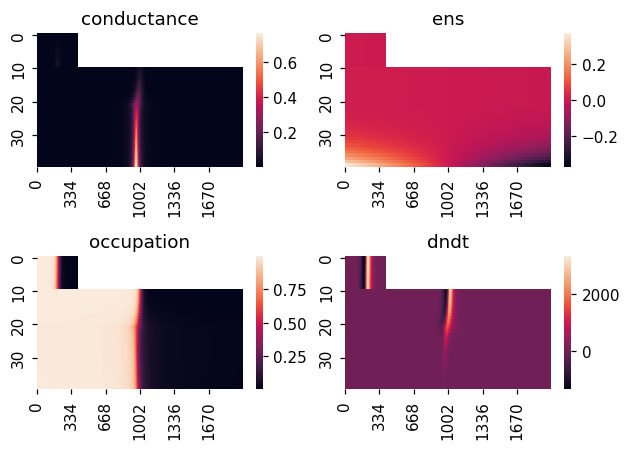

In [8]:
attrs_2d = list(set(attrs) - {"ts", "gs"})

fig, axs = plt.subplots(2, 2, figsize=(FS, FS * 0.7))
axs = axs.flatten()

for attr, ax in zip(attrs_2d, axs):
    ax: plt.Axes
    sns.heatmap(ax=ax, data=getattr(data, attr))
    ax.set_title(f"{attr}")
    ax.set_xticks(ax.get_xticks()[::2])
    ax.set_yticks(ax.get_yticks()[::2])

fig.tight_layout()

The mismatch in data shape can be seen here, where the rows 0-9 are from the narrow dataset and are filled with `np.nan` to match the data shape of the wider data

Note that for the new NRG data, entropy and int_dndt have **NOT** been calculated directly as this is a very expensive operation. However, the `dndt` data is sufficient to obtain the entropy changes given that entropy ends at $\ln(2)$ on the occupied side over the full calculated range.

The `ens` array is the x-axis (effectively sweep gate) data for all of the other datasets

For example, if we use the `ens` to plot some narrow and wide data we get:

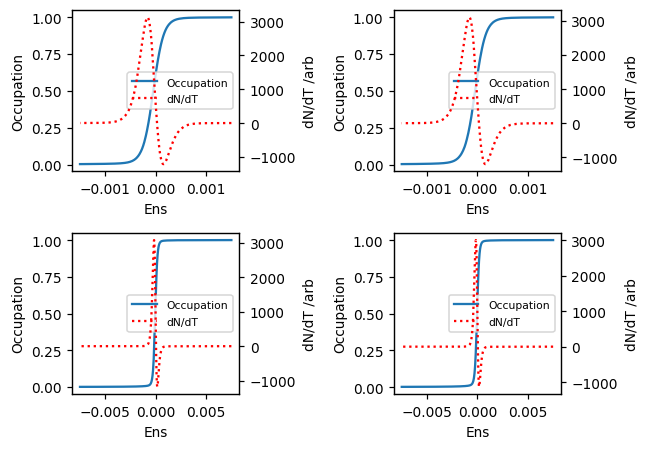

In [9]:
rows = [8, 9, 10, 11]  # rows around the change from narrow to wide datasets

fig, axs = plt.subplots(2, 2, figsize=(FS, FS * 0.7))
axs = axs.flatten()

for r, ax in zip(rows, axs):
    x = data.ens[r]
    occ_data = data.occupation[r]
    dndt_data = data.dndt[r]

    ax.plot(x, occ_data, label="Occupation")
    ax.set_xlabel("Ens")
    ax.set_ylabel("Occupation")
    ax.plot([], [], "r:", label="dN/dT")
    ax.legend(loc="center right", fontsize=8)
    decrease_fontsize(ax, 1)

    ax2 = ax.twinx()
    ax2.plot(x, dndt_data, "r:")
    ax2.set_ylabel("dN/dT /arb")
    ax2.tick_params(axis="both")
    decrease_fontsize(ax2, 1)


fig.tight_layout()

Note that the dndt data is scaled such that integrating (taking into account the ens spacing) results in close to, but not exactly the expected $\ln(2)$ total entropy change (see below).

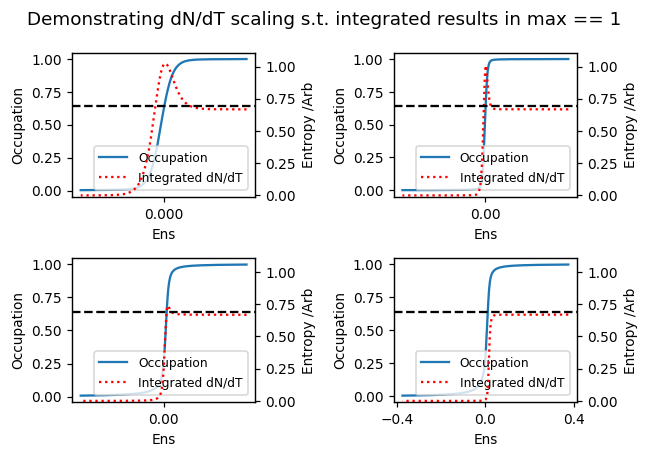

In [10]:
rows = [8, 11, 23, 39]

fig, axs = plt.subplots(2, 2, figsize=(FS, FS * 0.7))
fig.suptitle(f"Demonstrating dN/dT scaling s.t. integrated results in max == 1")
axs = axs.flatten()

for r, ax in zip(rows, axs):
    x = data.ens[r]
    occ_data = data.occupation[r]
    dndt_data = data.dndt[r]
    int_data = np.nancumsum(dndt_data) * np.nanmean(np.diff(x))
    int_data = int_data - np.nanmin(int_data)

    ax.plot(x, occ_data, label="Occupation")
    ax.set_xlabel("Ens")
    ax.set_ylabel("Occupation")
    ax.plot([], [], "r:", label="Integrated dN/dT")
    ticks = ax.get_xticks()
    ax.set_xticks(ticks[1 if len(ticks) % 4 - 1 else 0 :: 2])
    ax.legend(loc="lower right", fontsize=9)
    decrease_fontsize(ax, 1)

    ax2 = ax.twinx()
    ax2.plot(x, int_data, "r:")
    ax2.set_ylabel("Entropy /Arb")
    ax2.set_ylim(-0.01, np.log(3) + 0.01)
    decrease_fontsize(ax2, 1)

    ax2.axhline(np.log(2), color="k", linestyle="--")

fig.tight_layout()

Note that the integrated entropy always ends close to but not quite $ln(2)$. I believe this is just an artifact from calculation, they *should* all integrate to $\ln(2)$. 

## Plotting combined NRG datasets

We can plot the data using the `ens` and `T/G` ratios to see what the full space of calculated data really looks like

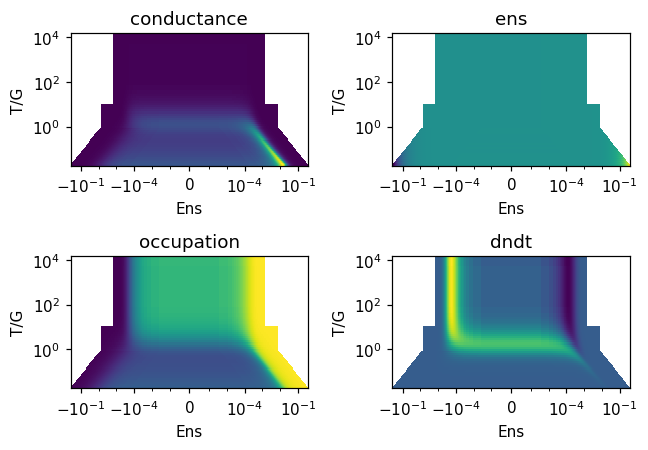

In [11]:
X = data.ens  # same shape as data2d
Y = data.ts / data.gs  # Only 1D

X1, X2 = X[0:10], X[10:]  # Narrow, Wide
X1 = X1[:, :401]

# Note: we want a meshgrid denoting corner points of pixels instead of centers
XXs = []
for X in X1, X2:
    x_stepsizes = np.array([np.mean(np.diff(_x)) for _x in X])
    # All step sizes should be the same (i.e. mean(diff) == diff[0])

    X = X + (x_stepsizes / 2)[:, None]  # Shift coords half a step to right
    XX = np.append(
        (X[:, 0] - x_stepsizes)[:, None], X, axis=1
    )  # Add a row of left side values starting half a step left
    XX = np.append(
        XX[0][None, :], XX, axis=0
    )  # Add an additional row to match with Y+1 shape, not ideal but ok enough...
    # Not ideal because I should be extrapolating what the stepsize would be
    XXs.append(XX)


Y = np.concatenate(
    ([Y[0] - (Y[1] - Y[0]) / 2], (Y[0:-1] + Y[1:]) / 2, [Y[-1] + (Y[-1] - Y[-2]) / 2])
)
# start-half first step, midpoints, end+half last step
# Y spacing is not equal, so mostly we want the midpoints between values
YYs = []
for XX in XXs:
    YY = np.repeat(
        Y[:, None], XX.shape[-1], axis=1
    )  # Convert to same x-axis shape as XXs
    YYs.append(YY)
YYs = [
    YYs[0][:11],
    YYs[1][10:],
]  # Convert to same y-axis shape as XXs (note both use same middle coord (YYs[10]))

fig, axs = plt.subplots(2, 2, figsize=(FS, FS * 0.7))
axs = axs.flatten()

for attr, ax in zip(attrs_2d, axs):
    data_ = getattr(data, attr)
    Zs = data_[0:10, :401], data_[10:]  # Only use Z part of data which matches XX

    for XX, YY, Z in zip(XXs, YYs, Zs):
        ax.pcolormesh(XX, YY, Z, vmin=np.nanmin(data_), vmax=np.nanmax(data_))
    ax.set_title(f"{attr}")
    ax.set_xlabel("Ens")
    ax.set_ylabel("T/G")
    ax.set_yscale("log")
    ax.set_xscale("symlog", linthresh=0.000001)
    xticks = ax.get_xticks()
    ax.set_xticks(xticks[1::3])
fig.tight_layout()

The graphs above are plotting with a **log** y-scale and **symlog** (symmetric log) x-scale


The key graphs here are the `dndt` and `occupation`, as these are the data we compare to.
`ens` highlights the symlog x-scale since the colorscale is just that of the x-values

# Fitting to NRG

## Parameters for Fitting

- **mid**: Position of N=0.5 occupation (only roughly N=0.5 for NRG - to get a more accurate center look at N=0.5 of occupation data)
- **theta**:  Thermal broadening
- **g**:  Gamma broadening

##### Specific to dndt
- **amp**: Scaling of dndt calculations

##### Specific to i_sense
- **amp**: Charge step size
- **const**:  Average Charge Sensor current
- **lin**:  Cross capacitance of gate on Charge Sensor
- **occ_lin**:  Change in `lin` as a fn of occupation (This is not often used)


## Making NRG functions that behave like analytical functions
In order to use this data for fitting routines, we require a function which can take **any** value of all fitting parameters (Gamma, Theta, En etc), so we need to interpolate between the nearest rows of data. And we might want to do this for any of the NRG datasets. From top down:

- One can get such a function from `NRG_func_generator(which='i_sense')` for a function for the specified data (e.g. `[i_sense, occupation, dndt]`)
    - i.e. This returns a function which takes all the usual fitting parameters - (x, mid, g, theta, amp, lin, const, occ_lin)
- It does so by wrapping `nrg_func(...)`; a function which takes all the regular parameters + which data is being requested
- That requests an interpolator from `_get_interpolator(...)` and then performs the interpolation with the values passed to return a value/array of answers
- `_get_interpolator(...)` takes the `theta/g` ratio, and name of data to figure out exactly which rows of data from which dataset needs to be interpolated.
    - To avoid having to rebuild the same interpolator over and over, this then calls a **cached** function `_cached_interpolator` which actually generates the interpolator. Note: `_get_interpolator(...)` cannot be cached as the call to it could have **any** value of `theta/g` even if they end up returning the same interpolator
- The `_cached_interpolator(...)` is called with an index and data name, so this has well-defined call arguments which can be cached so future calls for the same interpolator don't have to be calculated again.
    - It takes the two consecutive rows of data that will be interpolated between
    - Does a 1D interpolation of the wider of the two rows of data to match the ens axis of the narrower data (wider/narrower in ens)
    - Then creates a 2D interpolator between the two rows of data
    - Converts the 2D interpolator into a function which takes the usual arguments (minus `[g, theta]`) and additionally:
        - Adds an option for `i_sense` data by taking into account `[mid, amp, lin, const, occ_lin]`
        - Scales dndt data with `amp` to help with arbitrary scaling of dndt calculations
    - Returns the function which takes the usual arguments

In [12]:
from typing import Union, Callable, Tuple
from scipy.interpolate import interp1d, RectBivariateSpline
from dat_analysis.core_util import get_data_index


def NRG_func_generator(which="i_sense") -> Callable[..., Union[float, np.ndarray]]:
    """
    Wraps the nrg_func in a way that can be used by lmfit. If not using lmfit, then just call nrg_func directly

    Args:
        which (): Which data to make a function for (i.e. 'i_sense', 'occupation', 'dndt', etc)

    Returns:
        nrg_func for named data
    """
    from functools import wraps

    @wraps(nrg_func)
    def wrapper(*args, **kwargs):
        return nrg_func(*args, **kwargs, data_name=which)

    return wrapper


def nrg_func(
    x,
    mid,
    g,
    theta,
    amp: float = 1,
    lin: float = 0,
    const: float = 0,
    occ_lin: float = 0,
    data_name="i_sense",
) -> Union[float, np.ndarray]:
    """
    Returns data interpolated from NRG results. I.e. acts like an analytical function for fitting etc.

    Note: Does not require amp, lin, const, occ_lin for anything other than 'i_sense' fitting (which just adds terms to
    occupation)
    Args:
        data_name (): Which NRG data to return (i.e. occupation, dndt, i_sense)

    Returns:

    """
    interper = _get_interpolator(t_over_gamma=theta / g, data_name=data_name)
    return interper(x, mid, g, theta, amp=amp, lin=lin, const=const, occ_lin=occ_lin)


def get_nrg_data(data_name: str):
    """Returns just the named data array from NRG data"""
    nrg = NRGData.from_mat()
    if data_name == "i_sense":
        z = 1 - nrg.occupation
    elif data_name == "ts":
        z = nrg.ts
    elif data_name == "gs":
        z = nrg.gs
    elif data_name == "occupation":
        z = nrg.occupation
    elif data_name == "dndt":
        z = nrg.dndt
    elif data_name == "conductance":
        z = nrg.conductance
    elif data_name == "ens":
        z = nrg.ens
    else:
        raise NotImplementedError(f"{data_name} not implemented")
    return z


def scale_x(x, mid, g, theta, inverse=False):
    """
    To rescale sweepgate data to match the ens of NRG (with varying theta).

    Note: The -g*(...) - theta*(...) is just to make the center roughly near OCC = 0.5 (which is helpful for fitting
    only around the transition)

    x_scaled ~ (x - mid) * nrg_theta / theta

    Args:
        inverse (): set True to reverse the scaling

    Returns:

    """
    if not inverse:
        x_shifted = (
            x - mid - g * (-2.2) - theta * (-1.5)
        )  # Just choosing values which make 0.5 occ be near 0
        x_scaled = x_shifted * 0.0001 / theta  # 0.0001 == nrg_T
        return x_scaled
    else:
        x_scaled = x / 0.0001 * theta  # 0.0001 == nrg_T
        x_shifted = x_scaled + mid + g * (-2.2) + theta * (-1.5)
        return x_shifted


def _get_interpolator(t_over_gamma: float, data_name: str = "i_sense") -> Callable:
    """
    Generates a function which acts like a 2D interpolator between the closest t_over_gamma values of NRG data.

    Returns:
        Effective interpolator function which takes same args as nrg_func
        i.e. (x, mid, g, theta, amp=1, lin=0, const=0, occ_lin=0)  where the optionals are only used for i_sense
    """
    ts, gs = [get_nrg_data(name) for name in ["ts", "gs"]]
    tgs = ts / gs
    # index = np.abs(tgs - t_over_gamma).argmin()
    index = get_data_index(tgs, t_over_gamma)
    index = (
        index if tgs[index] > t_over_gamma else index - 1
    )  # want the true value to be between interpolated rows
    if index < 0:  # Asking for data outside of calculation range
        index = 0
    elif (
        index > len(tgs) - 2
    ):  # -2 because cached interpolator is going to look at next row as well
        index = len(tgs) - 2
    return _cached_interpolator(lower_index=index, data_name=data_name)


@lru_cache(
    maxsize=100
)  # Shouldn't ever be more than XX rows of NRG data (XX == size of data in .mat files)
def _cached_interpolator(lower_index: int, data_name: str) -> Callable:
    """
    Actually generates the scipy 2D interpolator for NRG data.
    This can be used for any future requests of this interpolator
    so this should be cached.

    Args:
        lower_index (): The lower index of NRG data to use for interpolation (will always interpolate between this and
            lower_index + 1)
        data_name (): Which NRG data to make an interpolator for

    Returns:
        2D interpolator function which takes x as an energy and y as a gamma/theta ratio.
    """

    def strip_x_nans(x: np.array, z: np.array) -> Tuple[np.ndarray, np.ndarray]:
        """Strip off NaNs that are in x array (and corresponding data)"""
        return x[np.where(~np.isnan(x))], z[np.where(~np.isnan(x))]

    ts, gs, ens, data = [
        get_nrg_data(name)[lower_index : lower_index + 2]
        for name in ["ts", "gs", "ens", data_name]
    ]
    tgs = ts / gs

    narrower_ens, narrower_data = ens[0], data[0]  # Just the
    wider_ens, wider_data = ens[1], data[1]

    narrower_ens, narrower_data = strip_x_nans(narrower_ens, narrower_data)
    wider_ens, wider_data = strip_x_nans(wider_ens, wider_data)

    single_interper = interp1d(
        x=wider_ens, y=wider_data, bounds_error=False, fill_value="extrapolate"
    )  # values are saturated near edge of NRG data,
    # so effectively constants for extrapolation

    interpolated_wider_data = single_interper(
        x=narrower_ens
    )  # i.e. mapping wider data to narrower ens

    # Note: Just returns edge value if outside interp range
    # flips are because x and y must be strictly increasing
    interper = RectBivariateSpline(
        x=np.flip(narrower_ens),
        y=np.flip(np.log10(tgs)),
        z=np.flip(np.array([narrower_data, interpolated_wider_data]).T, axis=(0, 1)),
        kx=1,
        ky=1,
    )
    # Note: the interpolator does not use the parts of the wider data that extend beyond the narrower data

    interp_func = _interper_to_nrg_func(interper, data_name)
    return interp_func


def _interper_to_nrg_func(interper, data_name: str):
    """Makes a function which takes normal fitting arguments and returns that function"""

    def func(x, mid, g, theta, amp=1, lin=0, const=0, occ_lin=0):
        x_scaled = scale_x(x, mid, g, theta)
        interped = interper(x_scaled, np.log10(theta / g)).flatten()
        if data_name == "i_sense":
            interped = (
                amp * (1 + occ_lin * (x - mid)) * interped
                + lin * (x - mid)
                + const
                - amp / 2
            )
            # Note: (occ_lin*x)*Occupation is a linear term which changes with occupation,
            # not a linear term which changes with x
        elif data_name == "dndt":
            interped *= amp
        elif data_name == "conductance":
            interped = amp * interped + const
        return interped

    return func

And a function for getting the `x` value that corresponds to a given occupation $N$.

In [13]:
def get_x_at_occupation(N, mid=0, theta=None, g=None) -> float:
    """
    Get x value at occupation N
    (Note that the NRG data has its own energy scale where 0 is only close to N=0.5)

    Args:
        mid (): Middle of transition based on fitting (this value will not be exactly N=0.5)
        theta (): Theta (thermal broadening)
        g (): Gamma (tunnel broadening)
    """
    # Make a high density x-array that will include N=0.5
    x = np.linspace(mid - 1000, mid + 1000, 100000)
    occ = nrg_func(x=x, mid=mid, g=g, theta=theta, data_name="occupation")
    # Get index where occ closest to N
    idx = np.abs(occ - N).argmin()
    # Return the x of that index
    return x[idx]

## Demonstration of NRG functions 

A couple of demonstrations of the use of these functions to generate data, although usually they will only be used for fitting

Notice that the true x value of N=0.5 is actually x=-2.1500, not 0


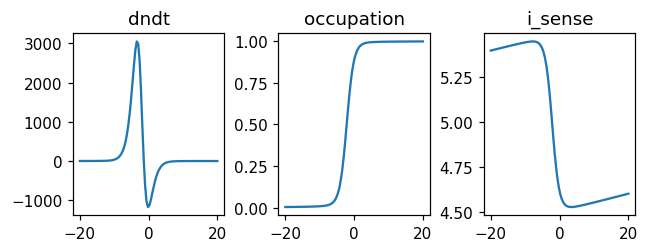

In [14]:
theta = 1
gamma = 0.1
amp = 1
mid = 0
const = 5
lin = 0.005
occ_lin = 0

x = np.linspace(-20, 20, 100)

data_names = ["dndt", "occupation", "i_sense"]

fig, axs = plt.subplots(1, 3, figsize=(FS, FS * 0.4))
axs = axs.flatten()

for name, ax in zip(data_names, axs):
    func = NRG_func_generator(which=name)
    data = func(
        x=x,
        mid=mid,
        amp=amp,
        const=const,
        lin=lin,
        occ_lin=occ_lin,
        g=gamma,
        theta=theta,
    )
    # Note that only x, mid, gamma, theta are used for all three datas, they are ignored for the wrong data types
    ax.plot(x, data)
    ax.set_title(f"{name}")

fig.tight_layout()
print(
    f"Notice that the true x value of N=0.5 is actually x={get_x_at_occupation(N=0.5, mid=mid, theta=theta, g=gamma):.4f}, not 0"
)

 Although the center of transition ($N = 0.5$) is close to but not quite $x = 0$. The NRG data as provided has an absolute zero given by the ens, however, this does not align with $N = 0.5$ (which makes sense since entropy should shift the occupation with temperature etc). 
 For comparison to experimental data, it is helpful to have the center of transition be close to $x = 0$ for ease of fitting (it is difficult to estimate a center value otherwise). This is achieved by shifting the x-axis of NRG data **AFTER** interpolation with the line:
 $$
 x_{\text{shifted}} = x - x_0 - \Gamma \times (-2.2) - \Theta \times(-1.5)
 $$
 where the factors $-2.2$ and $-1.5$ were found through trial and error to result in the $N=0.5$ being close to $x=0$
 
 And then scaling to account for thermal broadening (which is OK to do because the calculations are dependent on $\Gamma/T$ ratio only) using:
 $$
 x_{\text{scaled}} = x_{\text{shifted}} \times \frac{0.0001}{\Theta}
 $$
 where $0.0001$ is the Theta value used in the NRG calculations

We can also plot 2D data using the generated function

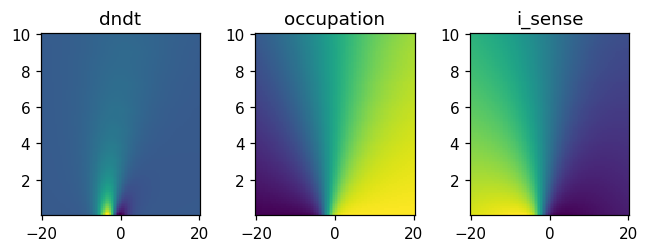

In [15]:
def xy_to_meshgrid(x, y):
    """returns a meshgrid that makes sense for pcolorgrid
    given z data that should be centered at (x,y) pairs"""
    nx = len(x)
    ny = len(y)

    dx = (x[-1] - x[0]) / float(nx - 1)
    dy = (y[-1] - y[0]) / float(ny - 1)

    # shift x and y back by half a step
    x = x - dx / 2.0
    y = y - dy / 2.0

    xn = x[-1] + dx
    yn = y[-1] + dy

    return np.meshgrid(np.append(x, xn), np.append(y, yn))


x = np.linspace(-20, 20, 100)
g_over_t = np.linspace(0.1, 10, 100)
theta = 1

gamma = g_over_t * theta

fig, axs = plt.subplots(1, 3, figsize=(FS, FS * 0.4))
axs = axs.flatten()

for name, ax in zip(data_names, axs):
    func = NRG_func_generator(which=name)
    data = np.array(
        [
            func(
                x=x,
                mid=mid,
                amp=amp,
                const=const,
                lin=lin,
                occ_lin=occ_lin,
                g=g,
                theta=theta,
            )
            for g in gamma
        ]
    )
    xx, yy = xy_to_meshgrid(x, g_over_t)
    ax.pcolormesh(xx, yy, data)
    ax.set_title(f"{name}")

fig.tight_layout()

## Fitting with NRG functions

For fitting to data, I use the `lmfit` package.

As an example, I will generate some fake `i_sense` data using the function demonstrated above


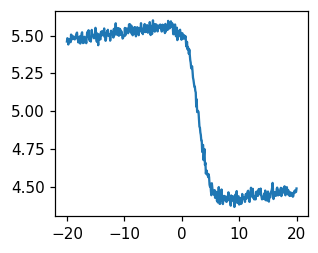

In [16]:
theta = 1
gamma = 0.005  # Very weakly coupled to start with
amp = 1.2
mid = 5
const = 5
lin = 0.005
occ_lin = 0

noise_fraction = 0.02

x = np.linspace(-20, 20, 500)

i_sense_func = NRG_func_generator(which="i_sense")
fake_data = i_sense_func(
    x=x, mid=mid, const=const, amp=amp, lin=lin, g=gamma, theta=theta, occ_lin=occ_lin
)
fake_data += np.random.normal(0, amp * noise_fraction, x.shape[0])

fig, ax = plt.subplots(figsize=(FS * 0.5, FS * 0.4))
ax.plot(x, fake_data)
fig.tight_layout()

Using the data above to demonstrate fitting to NRG

We'll need to make some initial guesses for fitting parameters. Typically, a function like the one below does a good enough job for starting parameters.

In [17]:
def guess_isense_params(
    x, data, g: float, g_vary: bool, theta: float, theta_vary: bool
) -> lm.Parameters:
    params = lm.Parameters()
    params.add_many(
        #            name, value, vary, min, max
        # Guess middle of dataset
        lm.Parameter("mid", np.nanmean(x), True, -100, 100),
        # Guess similar to amplitude of total data
        lm.Parameter("amp", np.nanmax(data) - np.nanmin(data), True, 0),
        # Generally requires quite strict limits
        lm.Parameter("lin", 0, True, 0, 0.1),
        # Roughly in middle of data
        lm.Parameter("const", np.nanmean(data), True),
        # Usually 5 works quite well, could do something more fancy if needed
        lm.Parameter("theta", theta, theta_vary, 0, 20),
        # Holding fixed near zero because fitting weakly coupled data
        lm.Parameter("g", g, g_vary, theta / 1000, theta * 50),
        # Usually not needed
        lm.Parameter("occ_lin", 0, False),
    )
    return params

### Fitting weakly coupled data

For fitting weakly coupled data (like the data above), the `g` value should be set small and forced not to vary, and theta should be allowed to vary.

In [18]:
params = guess_isense_params(x, data, g=0.001, g_vary=False, theta=5, theta_vary=True)

Note that the parameter `g` cannot be set exactly to zero and is **NOT** allowed to vary here (since we are trying to fit weakly coupled data).
In fact, even with `g` set 5x lower than the generated data, we should get a good fit since we are in the weakly coupled regime.
Also not allowing `occ_lin` to vary just because that is generally not needed

In [19]:
func = NRG_func_generator(which="i_sense")

model = lm.model.Model(func)
fit = model.fit(fake_data, x=x, params=params, method="powell", nan_policy="omit")

Note: The fitting method has been specified as `powell` rather than the default `leastsq`.

I experimented with many other fitting modes and found `powell` to be most reliable. I believe this is because of the discontinuous gradient of the interpolated data (i.e. corners at each calculated value)

In [20]:
print("Comparison of Expected vs Fit values\nName\t\tExpected\t\tFit")
for expected, name in zip(
    [mid, amp, const, lin, theta, gamma, occ_lin],
    ["mid", "amp", "const", "lin", "theta", "g", "occ_lin"],
):
    par = fit.params.get(name)
    print(f"{name:10}\t\t{expected:.1f}\t\t{par.value:.2f}\u00b1{par.stderr:.2f}")

Comparison of Expected vs Fit values
Name		Expected		Fit
mid       		5.0		4.99±0.04
amp       		1.2		1.20±0.01
const     		5.0		5.00±0.00
lin       		0.0		0.00±0.00
theta     		1.0		1.00±0.02
g         		0.0		0.01±0.00
occ_lin   		0.0		0.00±0.00


Or we can look at the full fit report

In [21]:
print(fit.fit_report())

[[Model]]
    Model(nrg_func)
[[Fit Statistics]]
    # fitting method   = Powell
    # function evals   = 812
    # data points      = 500
    # variables        = 5
    chi-square         = 0.27294246
    reduced chi-square = 5.5140e-04
    Akaike info crit   = -3746.55119
    Bayesian info crit = -3725.47815
    R-squared          = 0.99792494
[[Variables]]
    mid:      4.98810340 +/- 0.04252290 (0.85%) (init = -9.094947e-16)
    amp:      1.19941503 +/- 0.00703026 (0.59%) (init = 0.9196366)
    lin:      0.00498214 +/- 2.6391e-04 (5.30%) (init = 0)
    const:    4.99934266 +/- 0.00152794 (0.03%) (init = 4.930602)
    theta:    0.99835231 +/- 0.01923735 (1.93%) (init = 5)
    g:        0.005 (fixed)
    occ_lin:  0 (fixed)
[[Correlations]] (unreported correlations are < 0.100)
    C(mid, theta)   = 0.940
    C(amp, lin)     = 0.938
    C(amp, theta)   = 0.697
    C(lin, const)   = 0.674
    C(mid, amp)     = 0.640
    C(lin, theta)   = 0.629
    C(amp, const)   = 0.603
    C(mid, li

And now lets plot the fit on the data

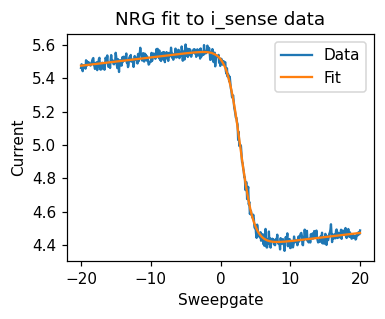

In [22]:
fig, ax = plt.subplots(figsize=(FS * 0.6, FS * 0.5))
ax.plot(x, fake_data, label="Data")
ax.plot(x, fit.eval(x=x), label="Fit")
ax.set_title(f"NRG fit to i_sense data")
ax.set_xlabel("Sweepgate")
ax.set_ylabel("Current")
ax.legend()
fig.tight_layout()

Because both g and theta are so strongly correlated, for fitting strongly coupled data (g > theta), it is necessary to hold theta fixed at the expected value.

### Fitting strongly coupled data
For strongly coupled data, `theta` should be set to it's expected value and set to NOT vary, while `g` can be set to vary (within limits of $0.001 < T < 50 T$).

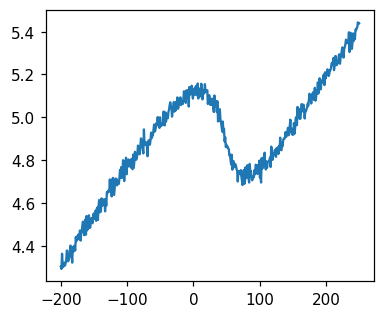

In [23]:
theta = 1
gamma = 15  # Made Gamma >> T
amp = 1.2
mid = 50
const = 5
lin = 0.005
occ_lin = 0

noise_fraction = 0.02

x = np.linspace(-200, 250, 500)  # Much wider x-axis

i_sense_func = NRG_func_generator(which="i_sense")
fake_data = i_sense_func(
    x=x, mid=mid, const=const, amp=amp, lin=lin, g=gamma, theta=theta, occ_lin=occ_lin
)
fake_data += np.random.normal(0, amp * noise_fraction, x.shape[0])

fig, ax = plt.subplots(figsize=(FS * 0.6, FS * 0.5))
ax.plot(x, fake_data)
fig.tight_layout()

Where the max/min points of the data are not near the transition sometimes causes issues with guessing amp as the max - min, but probably it is OK with this.

This time, we will allow `g` to vary while fitting, but hold `theta` fixed at the expected value. And we'll use the same model for the fitting

In [24]:
# Generate new params
params = guess_isense_params(x, data, g=5, g_vary=True, theta=theta, theta_vary=False)

# Using same model as previously
fit = model.fit(fake_data, x=x, params=params, method="powell", nan_policy="omit")

Comparison of Expected vs Fit values
Name		Expected		Fit
mid       		 50.0		49.76±0.31
amp       		  1.2		1.16±0.02
const     		  5.0		5.00±0.00
lin       		  0.0		0.00±0.00
theta     		  1.0		1.00±0.00
g         		 15.0		14.13±0.36
occ_lin   		  0.0		0.00±0.00


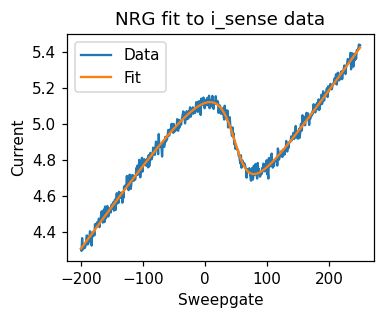

In [25]:
print("Comparison of Expected vs Fit values\nName\t\tExpected\t\tFit")
for expected, name in zip(
    [mid, amp, const, lin, theta, gamma, occ_lin],
    ["mid", "amp", "const", "lin", "theta", "g", "occ_lin"],
):
    par = fit.params.get(name)
    print(f"{name:10}\t\t{expected:5.1f}\t\t{par.value:.2f}\u00b1{par.stderr:.2f}")

fig, ax = plt.subplots(figsize=(FS * 0.6, FS * 0.5))
ax.plot(x, fake_data, label="Data")
ax.plot(x, fit.eval(x=x), label="Fit")
ax.set_title(f"NRG fit to i_sense data")
ax.set_xlabel("Sweepgate")
ax.set_ylabel("Current")
ax.legend()
fig.tight_layout()

As expected, a good fit to fake_data

Now let's fit the data. We'll change the initial params first so that we aren't cheating too much

Again we see a good fit. Note that there are several fitting parameters shown above that are not used and are just held fixed.

# Plotting vs Occupation
Instead of plotting an energy/sweepgate values on the x-axis, let's plot against occupation instead. This will be useful for comparing measurements at varying G/T ratios

This is achieved by using the same parameters (specifically the `g`, `theta`, and `mid`) values to generate the expected Occupation data.
We'll just skip to using the useful functions to do this.

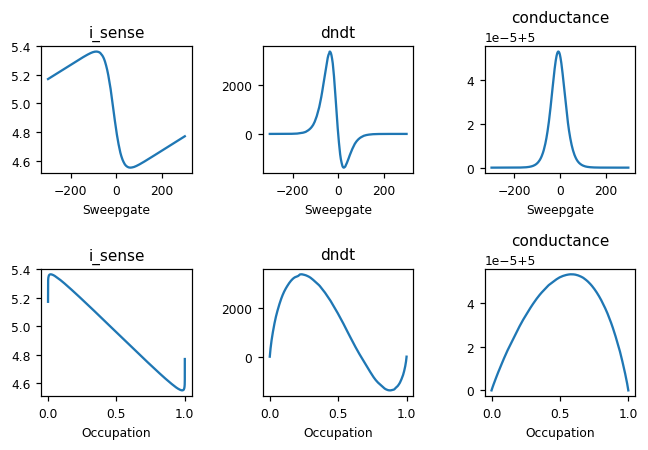

In [26]:
mid = 30
amp = 1
theta = 20
g = 0.001
lin = 0.001
const = 5
occ_lin = 0

x = np.linspace(-300, 300, 1000)
occ_x = nrg_func(x, mid, g, theta, data_name="occupation")


data_names = ["i_sense", "dndt", "conductance"]
fig, axs = plt.subplots(2, 3, figsize=(FS, FS * 0.7))

for name, ax in zip(data_names, axs[0, :]):
    # data = nrg_helper.data_from_params(x=x, which_data=name, which_x="sweepgate")
    data = nrg_func(x, mid, g, theta, lin=lin, const=const, data_name=name)
    ax.plot(x, data)
    ax.set_title(name)
    ax.set_xlabel("Sweepgate")
    decrease_fontsize(ax, 2)

for name, ax in zip(data_names, axs[1, :]):
    data = nrg_func(x, mid, g, theta, lin=lin, const=const, data_name=name)
    ax.plot(occ_x, data)
    ax.set_title(name)
    ax.set_xlabel("Occupation")
    decrease_fontsize(ax, 2)

fig.tight_layout()

As expected, the `i_sense` data is linear when plotted against Occupation (excluding the edges). The non-zero linear term results in vertical lines at either end (i.e. changing current with no change of occupation).

Plotting $dN/dT$ this way makes it much easier to compare $dN/dT$ for varying $\Gamma/T$. Same goes for conductance data

e.g.

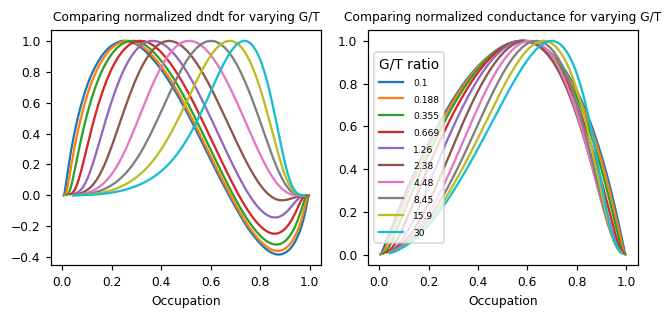

In [27]:
g_over_ts = np.logspace(np.log10(0.1), np.log10(30), 10)
mid = 0
theta = 10
# g -- defined in loop based on G/T ratios
# print("Ratios to plot: ", [f"{gt:.3g}" for gt in g_over_ts])

fig, axs = plt.subplots(1, 2, figsize=(FS, FS * 0.5))
axs = axs.flatten()
for data_name, ax in zip(["dndt", "conductance"], axs):
    for gt in g_over_ts:
        g = gt * theta
        x = np.linspace(
            -max([theta, gt * theta]) * 15, max([theta, gt * theta]) * 15, 300
        )  # Wider x needed for wider data
        occ_x = nrg_func(x, mid, g, theta, data_name="occupation")
        data = nrg_func(x, mid, g, theta, data_name=data_name)
        data = data / np.nanmax(data)
        ax.plot(occ_x, data, label=f"{gt:.3g}")
        # ax.plot(x, data, label=f"{gt:.3g}")

    if data_name == "conductance":
        leg = ax.legend(title="G/T ratio", loc="center left", fontsize=8)
        leg.get_title().set_fontsize(9)
    ax.set_title(f"Comparing normalized {data_name} for varying G/T", fontsize=10)
    ax.set_xlabel("Occupation")
    decrease_fontsize(ax, 2)
    # ax.set_ylabel("Normalized Delta Current")

fig.tight_layout()